<a href="https://colab.research.google.com/github/carinunez/ControlNet/blob/main/Paper_ControlNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install diffusers transformers accelerate opencv-python torch torchvision datasets

In [ ]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5");
pipe = pipe.to("cuda")

In [3]:
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from diffusers.schedulers import DDIMScheduler
from types import MethodType
import os
from IPython.display import display
import copy

In [4]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, Dataset as HFDataset
from PIL import Image
import torchvision.transforms as T


# DATOS

In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
import json
prompts_json = ['prompts.json', 'prompts200_400.json', 'prompts400_600.json',
           'prompts600_end.json']

prompt_dict = {}
for jsons in prompts_json:
  with open(os.path.join("/content/gdrive/MyDrive/", jsons), 'r') as file:
      prompt_dict.update(json.load(file))

In [7]:
image_dir = "/content/gdrive/MyDrive/img_pkmn"
canny_dir  ="/content/gdrive/MyDrive/canny"

if not os.path.isdir(canny_dir):
    os.makedirs(canny_dir)

def apply_canny_path(image: Image.Image, im_path) -> Image.Image:

    img = np.array(image.convert("RGB"))
    edges = cv2.Canny(img, 100, 200)
    edges = np.stack([edges] * 3, axis=-1)  # convertir a 3 canales
    edges = Image.fromarray(edges)
    edges.save(os.path.join(canny_dir, f'canny_{im_path}'))
    return edges


# data = []
# for im_path in os.listdir(image_dir):
#   img = load_images(image_dir, im_path)
#   # canny = apply_canny_path(img, im_path)
#   canny = load_images(canny_dir, f'canny_{im_path}')
#   prompt = "a colorful pokemon"
#   data.append({"image": img, 'canny':canny, "text": prompt_dict[im_path]})

# dataset_hf = HFDataset.from_list(data)

In [8]:
def build_dataset(image_dir, canny_dir, prompt_dict):

    dataset = []
    for im_path in os.listdir(image_dir):
        dataset.append({
            "image_path": os.path.join(image_dir, im_path),
            "canny_path": os.path.join(canny_dir, f'canny_{im_path}'),
            "text": prompt_dict[im_path]
        })
    return dataset

def save_dataset_json(dataset, save_path="dataset.json"):
    with open(save_path, "w") as f:
        json.dump(dataset, f, indent=2)

image_dir = "/content/gdrive/MyDrive/img_pkmn"
canny_dir  ="/content/gdrive/MyDrive/canny"

dataset = build_dataset(image_dir, canny_dir, prompt_dict)
save_dataset_json(dataset, "dataset.json")

a bird with a black and white beak


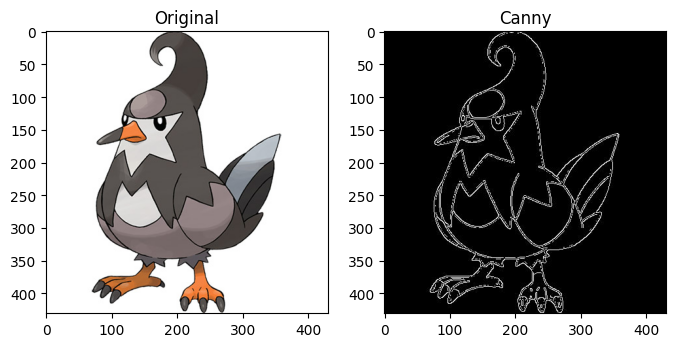

In [9]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 12))
ax1.imshow(Image.open(dataset[1]['image_path']));
ax1.set_title('Original');
ax2.imshow(Image.open(dataset[1]['canny_path']));
ax2.set_title('Canny');
print(dataset[1]['text'])

In [10]:
class ControlDataset(Dataset):
    def __init__(self, dataset_json, size=64):
        with open(dataset_json, "r") as f:
          self.dataset = json.load(f)
        self.image_trans = T.Compose([
            T.Resize((size, size)),
            T.ToTensor(),
            T.Normalize([0.5]*3, [0.5]*3)  # RGB
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        # Lazy-load the images from disk
        img = Image.open(sample['image_path']).convert('RGB')
        ctrl = Image.open(sample['canny_path']).convert('RGB')

        # Apply transforms
        img = self.image_trans(img)
        ctrl = self.image_trans(ctrl)
        prompt = sample['text']

        return img, ctrl, prompt


In [11]:
# Dataloader
train_dataloader = DataLoader(ControlDataset('dataset.json', size=512),
                              batch_size=2, shuffle=True)

In [12]:
for img, ctrl, prompt in train_dataloader:
    print(img.shape, ctrl.shape, prompt)
    break

torch.Size([2, 3, 512, 512]) torch.Size([2, 3, 512, 512]) ('a blue pokemon pokemon', 'a cartoon character with a big purple bat')


# Clases de 0

In [13]:
class ConditionEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1),  # 256→128
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # 128→64
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64→32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32→16
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.blocks(x)  # [B, 128, 32, 32]
        # Upsample para coincidir con tamaño de input a ControlBlock (64×64)
        x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)
        return x


In [14]:
class ZeroConv(nn.Conv2d):
    def reset_parameters(self):
        nn.init.zeros_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

class ControlBlock(nn.Module):
    def __init__(self, base_block, in_channels):
        super().__init__()
        self.locked_block = base_block.eval()

        out_channels = base_block.out_channels # check later

        for p in self.locked_block.parameters():
            p.requires_grad = False

        self.trainable_block = copy.deepcopy(base_block)
        self.zero_conv1 = ZeroConv(in_channels, out_channels, kernel_size=1)
        self.zero_conv2 = ZeroConv(out_channels, out_channels, kernel_size=1)

    def forward(self, x, condition, temb=None):
        zc1 = self.zero_conv1(condition)
        assert zc1.shape == x.shape, f"Shape mismatch: {zc1.shape} vs {x.shape}"

        x_cond = x + zc1
        y_trainable = self.trainable_block(x_cond, temb=temb)
        y_final = self.locked_block(x, temb=temb) + self.zero_conv2(y_trainable)
        return y_final

In [15]:
class ControlNetWrapper(nn.Module):
    def __init__(self, unet, control_blocks, condition_encoder):
        super().__init__()
        self.unet = unet.eval()  # U-Net congelada
        self.control_blocks = control_blocks  # Lista de ControlBlocks
        self.condition_encoder = condition_encoder.eval()  # Congelada en inferencia
        # self.down_blocks = unet.down_blocks
        # self.up_blocks = unet.up_blocks
        # self.mid_block = unet.mid_block

        # congelar todo
    def freeze(self):
        for p in self.unet.parameters():
            p.requires_grad = True

        for cb in self.control_blocks:
            for p in cb.parameters():
                p.requires_grad = False

        for p in self.condition_encoder.parameters():
            p.requires_grad = False

    def forward(self, sample, timestep, encoder_hidden_states, condition=None, **kwargs):
        # sample: el latente z_t (ruido)
        # condition: imagen tipo Canny como tensor (B x 3 x 512 x 512)

        if condition is None:
            raise ValueError("Falta la condición visual en el forward")

        # Codificar la condición visual
        cond_feat = self.condition_encoder(condition)

        x = self.unet.conv_in(sample) #injecta los control blocks

        temb = self.unet.time_proj(timestep)
        temb = self.unet.time_embedding(temb)

        # Aplicar los bloques de ControlNet en secuencia
        for i, control_block in enumerate(self.control_blocks):
            x = control_block(x, cond_feat, temb=temb)

        # Pasar a la U-Net congelada
        return self.unet(x, timestep, encoder_hidden_states=encoder_hidden_states, **kwargs)

In [16]:
scheduler = DDIMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

vae = pipe.vae.to('cuda')
text_encoder = pipe.text_encoder.to('cuda')
tokenizer = pipe.tokenizer

vae.eval()
text_encoder.eval()
unet = pipe.unet.eval()  # congelado

# Freeze U-Net
for p in unet.parameters():
    p.requires_grad = True

for p in vae.parameters():
    p.requires_grad = False

for p in text_encoder.parameters():
    p.requires_grad = False

In [17]:
# Parche a stable diffusion pipeline
def patched_call(self, *args, **kwargs):
    # condition = kwargs.get("condition", None)

    # if "condition" not in kwargs:
    #     kwargs["condition"] = condition
    return self.__class__.original_call(self, *args, **kwargs)

# Parchear stable diffussion para darle la condición
StableDiffusionPipeline.original_call = StableDiffusionPipeline.__call__
StableDiffusionPipeline.__call__ = MethodType(patched_call, pipe)

In [18]:
# Encoder de condiciones minimal
condition_encoder = ConditionEncoder().to("cuda")

# Bloque 1 (igual que ya tienes)
control_block1 = ControlBlock(
    base_block=pipe.unet.down_blocks[0].resnets[0],
    in_channels=128
).to("cuda")

# Bloque 2 (segundo resnet del mismo down_block)
control_block2 = ControlBlock(
    base_block=pipe.unet.down_blocks[0].resnets[1],
    in_channels=128
).to("cuda")



In [19]:
wrapper = ControlNetWrapper(
    unet= pipe.unet,
    control_blocks=[control_block1, control_block2],
    condition_encoder=condition_encoder
).to('cuda')

# Reemplaza la unet del pipeline
pipe.unet = wrapper

In [20]:
pipe.unet.unet.down_blocks[0].resnets[0]


ResnetBlock2D(
  (norm1): GroupNorm(32, 320, eps=1e-05, affine=True)
  (conv1): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb_proj): Linear(in_features=1280, out_features=320, bias=True)
  (norm2): GroupNorm(32, 320, eps=1e-05, affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (conv2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (nonlinearity): SiLU()
)

In [21]:
pipe.unet.config = pipe.unet.unet.config


In [22]:
#  Optimizador
optimizer = torch.optim.Adam(
    list(control_block1.parameters()) + list(control_block2.parameters()),
    lr=1e-4
)

# Entrenamiento simple
# Steps
step = 0
for epoch in range(3):
    for imgs, conds, captions in tqdm(train_dataloader):
        imgs, conds = imgs.to("cuda"), conds.to("cuda")

        # 1. Codifica imagen a latente limpio
        latents = vae.encode(imgs).latent_dist.sample() * 0.18215

        # 2. Samplea paso de ruido
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps,
                                  (latents.shape[0],), device=latents.device).long()

        # 3. Agrega ruido
        noisy_latents = scheduler.add_noise(latents, noise, timesteps)

        # 4. Codifica texto (prompt)
        text_inputs = tokenizer(captions, padding="max_length", max_length=77,
                                return_tensors="pt").to("cuda")
        text_embeddings = text_encoder(text_inputs.input_ids)[0]

        # 5. Codifica condición visual
        cond_feat = condition_encoder(conds)

        # 6. Pasa por ControlNet (tus bloques)
        x = pipe.unet.unet.conv_in(noisy_latents)

        temb = pipe.unet.unet.time_proj(timesteps)
        temb = pipe.unet.unet.time_embedding(temb)

        print("Shape 2",cond_feat.shape)
        print("Shape x 2",x.shape)
        x = control_block1(x, cond_feat, temb=temb)
        x = control_block2(x, cond_feat, temb=temb)

        # 7. Predice el ruido con U-Net congelado
        noise_pred = unet(
                        noisy_latents, timesteps,
                        encoder_hidden_states=text_embeddings
                        ).sample

        # 8. Loss entre ruido predicho y ruido real
        loss = torch.nn.functional.mse_loss(noise_pred, noise)


        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(f"[Epoch {epoch}] Step {step} - Loss: {loss.item()}")

        # Visualización cada 100 pasos
        if step % 10 == 0:
            with torch.no_grad():
                # pipe.unet = wrapper  # Asegura que pipe use el wrapper
                img_out = pipe(prompt=captions[0], condition=conds[0].unsqueeze(0)).images[0]
                display(img_out)

        del latents, x, cond_feat, noise_pred
        torch.cuda.empty_cache()
        step += 1  # ← avanzar contador

  0%|          | 0/417 [00:00<?, ?it/s]

Shape 2 torch.Size([2, 128, 64, 64])
Shape x 2 torch.Size([2, 320, 64, 64])
[Epoch 0] Step 0 - Loss: 0.0024747420102357864


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/417 [00:05<?, ?it/s]


ValueError: Falta la condición visual en el forward

In [ ]:
captions[0]

In [ ]:
pipe(prompt=captions[0], condition=conds[0]).images[0]

In [ ]:
torch.save({
    "encoder": condition_encoder.state_dict(),
    "cb1": control_block1.state_dict(),
    "cb2": control_block2.state_dict()
}, "controlnet_minimal.pth")

#Inferencia

In [ ]:
pipe.enable_attention_slicing()

example = dataset[0]
cond = transform(example["condition"]).unsqueeze(0).to("cuda")
caption = example["caption"]

# Ejecutar como siempre, pero ahora pasas la condición
with torch.no_grad():
    image = pipe(prompt=caption, condition=cond).images[0]

image.show()
